In [1]:
import torch
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader
import torchvision.datasets
import torch.nn as nn
from torchvision.transforms import ToTensor
from os.path import expanduser
import os

loadSaveFile = False
saveFile = expanduser("./mnist-save.dat")

dataFolder = expanduser(".")
os.makedirs(dataFolder, exist_ok=True)


train_ds = torchvision.datasets.MNIST(root=dataFolder, download=True, train=True, transform=ToTensor())
test_ds = torchvision.datasets.MNIST(root=dataFolder, download=True, train=False, transform=ToTensor())

train_dl = DataLoader(dataset=train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(dataset=train_ds, batch_size=128)

def convolution(inChannels, outChannels, useMaxPool=False):
    conv = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    bn = nn.BatchNorm2d(num_features=outChannels)
    relu = nn.ReLU()

    if useMaxPool:
        return nn.Sequential(conv, bn, relu, nn.MaxPool2d(2))
    else:
        return nn.Sequential(conv, bn, relu)

class MnistDataset(nn.Module):
    def __init__(self):
        super(MnistDataset, self).__init__()
        self.initLayer = convolution(1, 32, True) # 14x14
        self.conv1 = nn.Sequential(convolution(32, 32), convolution(32, 32))
        self.middleLayer = convolution(32, 64, True) # 7x7
        self.conv2 = nn.Sequential(convolution(64, 64), convolution(64, 64))
        self.classifier = nn.Sequential(
            nn.MaxPool2d(7),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.initLayer(x)
        out = self.conv1(out) + out
        out = self.middleLayer(out)
        out = self.conv2(out) + out
        return self.classifier(out)


def getDefaultDevice():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = getDefaultDevice()
print("device=", device)

def toDevice(data, device):
    if isinstance(data, list):
        return [toDevice(d, device) for d in data]
    else:
        return data.to(device)

class DeviceDataLoader:
    def __init__(self, device, dataLoader):
        self.device = device
        self.dataLoader = dataLoader

    def __len__(self):
        return len(self.dataLoader)

    def __iter__(self):
        for d in self.dataLoader:
            yield toDevice(d, self.device)


train_dl = DeviceDataLoader(device, train_dl)
test_dl = DeviceDataLoader(device, test_dl)

numEpoch = 20
model = MnistDataset()
model.to(device)

if loadSaveFile:
    model.load_state_dict(torch.load(saveFile, map_location=device))


device= cuda


In [2]:
optimizer = torch.optim.SGD(model.parameters(), lr=10e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 10e-2, epochs=numEpoch, steps_per_epoch=len(train_dl))



def calculateAccuracy(yPredicted, y):
    _, yMax = torch.max(yPredicted, dim=1)
    return torch.tensor(torch.sum(yMax == y).item() / len(y))


for epoch in range(numEpoch):
    model.train()
    i = 0
    for x, y in train_dl:
        optimizer.zero_grad()
        yPredicted = model(x)
        loss = cross_entropy(yPredicted, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        i = i + 1

    model.eval()
    losses = []
    correct = 0
    total = 0
    for x, y in test_dl:
        yPredicted = model(x)
        loss = cross_entropy(yPredicted, y).detach()
        losses.append(loss)

        total += y.size(0)
        _, yMax = torch.max(yPredicted, dim=1)
        correct += (yMax == y).sum().item()
    avgLoss = torch.stack(losses).mean()
    accuracy = correct / total * 100
    print("loss=", avgLoss, "acc=", accuracy,"%")

torch.save(model.state_dict(), saveFile)

loss= tensor(0.0932, device='cuda:0') acc= 97.23666666666666 %
loss= tensor(0.1981, device='cuda:0') acc= 94.73166666666667 %
loss= tensor(0.0349, device='cuda:0') acc= 98.91 %
loss= tensor(0.0249, device='cuda:0') acc= 99.24833333333333 %
loss= tensor(0.0294, device='cuda:0') acc= 99.14166666666667 %
loss= tensor(0.0232, device='cuda:0') acc= 99.285 %
loss= tensor(0.0203, device='cuda:0') acc= 99.39 %
loss= tensor(0.0085, device='cuda:0') acc= 99.76333333333334 %
loss= tensor(0.0088, device='cuda:0') acc= 99.71333333333334 %
loss= tensor(0.0098, device='cuda:0') acc= 99.695 %
loss= tensor(0.0109, device='cuda:0') acc= 99.65 %
loss= tensor(0.0122, device='cuda:0') acc= 99.66000000000001 %
loss= tensor(0.0160, device='cuda:0') acc= 99.50833333333333 %
loss= tensor(0.0026, device='cuda:0') acc= 99.92666666666666 %
loss= tensor(0.0015, device='cuda:0') acc= 99.96833333333333 %
loss= tensor(0.0011, device='cuda:0') acc= 99.97 %
loss= tensor(0.0007, device='cuda:0') acc= 99.98833333333333 %

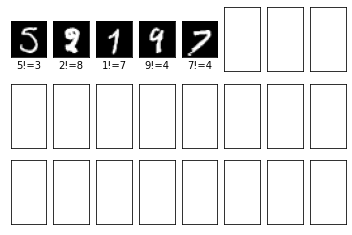

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

width=8
height=3
plotX = 0
plotY = 0

f, axarr = plt.subplots(3,8)
plt.setp(axarr, xticks=[],yticks=[])

for x, y in test_dl:
    yPredicted = model(x)
    _, yMax = torch.max(yPredicted, dim=1)
    for i, yCurrent in enumerate(yMax):
      if yCurrent != y[i]:
        axarr[plotY,plotX].imshow(x[i][0].cpu(), cmap="gray")
        label=str(yCurrent.item()) + "!=" + str(y[i].item())
        axarr[plotY,plotX].set(xLabel=label)

        plotX = plotX + 1
        if plotX >= width:
          plotY = plotY + 1
          if plotY >= height:
            break
          plotX = 0
    if plotY >= height:
      break
plt.show()